**AI 노바투스과정**

Week 4: 딥러닝 기초 II (2021-08-27)

실습 #2: 순환 신경망 학습 실습하기

iteration 219

multi-step forecasting

TimeDistributed

GRU

런타임 GPU

In [15]:
### 필요 패키지 불러오기

import numpy as np
import tensorflow.keras as keras
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

In [16]:
### 그래프 그리는 함수 만들기

def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
  n_steps = series.shape[0]
  plt.plot(series, ".-", label='x')
  if y is not None:
    plt.plot(n_steps, y, "bx", label='actual y', markersize=10)
  if y_pred is not None:
    plt.plot(n_steps, y_pred, "ro", label="predicted y")
  plt.grid(True)
  if x_label:
    plt.xlabel(x_label, fontsize=16)
  if y_label:
    plt.ylabel(y_label, fontsize=16, rotation=0)
  plt.hlines(0, 0, 100, linewidth=1)
  plt.axis([0, n_steps + 1, None, None])
  plt.legend()

def plot_multiple_forecasts(X, Y, Y_pred):
  n_steps = X.shape[1]
  ahead = Y.shape[1]
  plot_series(X[0, :, 0])
  plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-",label="Actual")
  plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-",label="Forecast", markersize=10)
  plt.axis([0, n_steps + ahead, None, None])
  plt.legend(fontsize=14)

## 0. 시계열 데이터셋 준비

In [17]:
### 시뮬레이션 데이터셋 생성을 위한 함수 만들기

import numpy as np

def generate_time_series(batch_size, n_steps):
  freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1) # batch_size만큼 4개
  time = np.linspace(0, 1, n_steps) # 0부터 1까지 n_steps 만큼
  series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10)) # wave 1
  series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
  series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5) # + noise
  return series[..., np.newaxis].astype(np.float32) # same as series[:, :, np.newaxis].astype(np.float32)


In [18]:
# 데이터셋 만들기

n_steps = 50
series = generate_time_series(10000, n_steps + 1)


In [19]:
np.shape(series)

(10000, 51, 1)

In [20]:
# train, validation, test set 으로 분리하기

X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1] #파라미터 조정
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]


In [21]:
np.shape(X_train)

(7000, 50, 1)

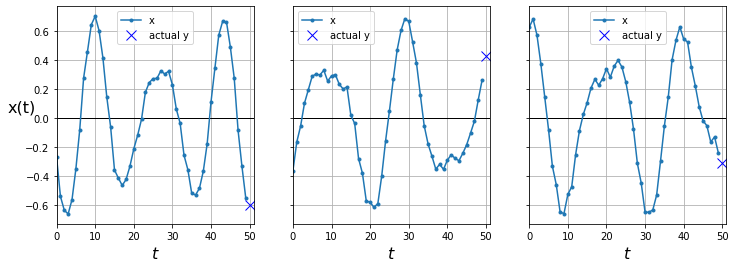

In [22]:
# plot_series() 함수로 데이터 살펴보기

import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
  plt.sca(axes[col])
  plot_series(X_train[col, :, :], y_train[col, :], y_label=("x(t)" if col==0 else None))
plt.show()

## 1. 완전 접속 신경망 구현하기

In [23]:
# gpu 설정
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [24]:

model=keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[50,1]))
model.add(keras.layers.Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

history=model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 3s 3ms/step - loss: 0.0691 - val_loss: 0.0275
Epoch 2/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0210 - val_loss: 0.0167
Epoch 3/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0136 - val_loss: 0.0121
Epoch 4/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0103 - val_loss: 0.0099
Epoch 5/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0086 - val_loss: 0.0087
Epoch 6/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0076 - val_loss: 0.0078
Epoch 7/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0069 - val_loss: 0.0069
Epoch 8/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0063 - val_loss: 0.0063
Epoch 9/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0058 - val_loss: 0.0059
Epoch 10/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0054 - val_loss: 0.0057

In [25]:
# 학습 결과 확인하기

model.evaluate(X_test, y_test)

32/32 [==============================] - 0s 2ms/step - loss: 0.0038


0.0037736662197858095

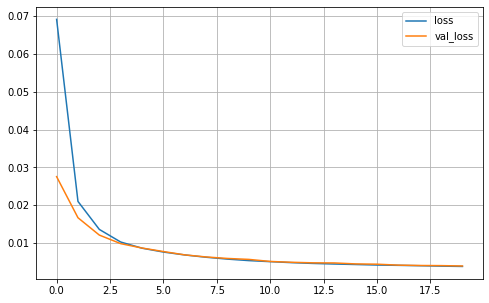

In [26]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)

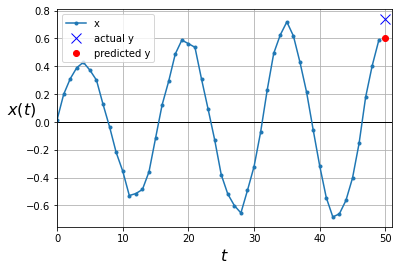

In [27]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, :], y=y_valid[0, :], y_pred=y_pred[0, :])
plt.show()

## 2. 단층 RNN 구현하기

In [30]:
# RNN 모형의 골격 만들기

with tf.device('/device:GPU:0'):
  model=keras.models.Sequential()
  model.add(keras.layers.SimpleRNN(1,input_shape=[None,1])) # Param 파라미터 아웃값 * (파라미터 아웃값 + 디멘션 값 +1(바이어스))
  # (output shape * output shape) + (output shape + input dim) + 1*input dim

In [31]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [32]:
#모형 컴파일 하기

model.compile(loss='mse', optimizer='adam')

In [33]:
# 모형 학습하기

history=model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 9s 35ms/step - loss: 0.6970 - val_loss: 0.5693
Epoch 2/20
219/219 [==============================] - 7s 34ms/step - loss: 0.4126 - val_loss: 0.3400
Epoch 3/20
219/219 [==============================] - 8s 34ms/step - loss: 0.3064 - val_loss: 0.2821
Epoch 4/20
219/219 [==============================] - 7s 34ms/step - loss: 0.2555 - val_loss: 0.2377
Epoch 5/20
219/219 [==============================] - 7s 34ms/step - loss: 0.2165 - val_loss: 0.2094
Epoch 6/20
219/219 [==============================] - 8s 34ms/step - loss: 0.1835 - val_loss: 0.1744
Epoch 7/20
219/219 [==============================] - 7s 34ms/step - loss: 0.1544 - val_loss: 0.1513
Epoch 8/20
219/219 [==============================] - 8s 36ms/step - loss: 0.1415 - val_loss: 0.1443
Epoch 9/20
219/219 [==============================] - 8s 34ms/step - loss: 0.1371 - val_loss: 0.1441
Epoch 10/20
219/219 [==============================] - 7s 34ms/step - loss: 0.1397 - val_lo

In [34]:
# 학습 결과 확인하기

model.evaluate(X_test, y_test)

32/32 [==============================] - 0s 5ms/step - loss: 0.1367


0.1366812139749527

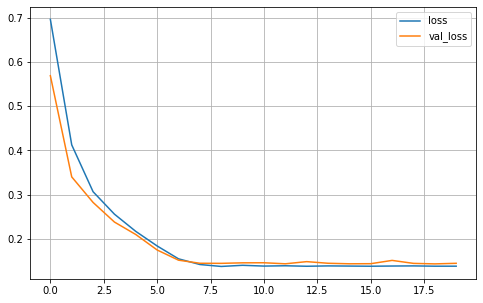

In [35]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)

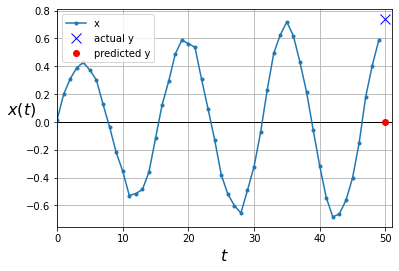

In [36]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, :], y_valid[0, :], y_pred[0, :])
plt.show()

## 3. 다층 RNN 구현하기

In [ ]:
# RNN 모형의 골격 만들기
with tf.device('/device:GPU:0'):
  model=keras.models.Sequential()
  model.add(keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None,1]))
  # return_sequences = True로 설정할 경우 각 time step별 hidden state를 모두 출력하게 된다. 예를들어 위의 예시에서 처럼 길이가 6인 경우에는 총 6개의 hidden state값이 모두 나오는 것이다.
  # Param 파라미터 아웃값 * (파라미터 아웃값 + 디멘션 값 +1(바이어스))
  # 20*(20+1+1) = 440
  model.add(keras.layers.SimpleRNN(20, return_sequences=True))
  # 20*(20+20+1) = 820
  model.add(keras.layers.SimpleRNN(1))
  # 1*(1+20+1) = 22

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, None, 20)          440       
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, None, 20)          820       
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 1)                 22        
                                                                 
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 모형 컴파일 하기

model.compile(loss='mse', optimizer='adam')

In [ ]:
# 모형 학습하기

history=model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))


Epoch 1/10
219/219 [==============================] - 27s 118ms/step - loss: 0.0286 - val_loss: 0.0073
Epoch 2/10
219/219 [==============================] - 25s 113ms/step - loss: 0.0058 - val_loss: 0.0046
Epoch 3/10
219/219 [==============================] - 26s 117ms/step - loss: 0.0046 - val_loss: 0.0042
Epoch 4/10
219/219 [==============================] - 26s 117ms/step - loss: 0.0040 - val_loss: 0.0036
Epoch 5/10
219/219 [==============================] - 25s 116ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 6/10
219/219 [==============================] - 27s 125ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 7/10
219/219 [==============================] - 26s 118ms/step - loss: 0.0034 - val_loss: 0.0038
Epoch 8/10
219/219 [==============================] - 26s 118ms/step - loss: 0.0034 - val_loss: 0.0037
Epoch 9/10
219/219 [==============================] - 25s 115ms/step - loss: 0.0033 - val_loss: 0.0029
Epoch 10/10
219/219 [==============================] - 26s 118ms/step - l

In [ ]:
np.shape(X_valid)

(2000, 50, 1)

In [ ]:
# 학습결과 확인하기

model.evaluate(X_test, y_test)

32/32 [==============================] - 0s 13ms/step - loss: 0.0032


0.003172379918396473

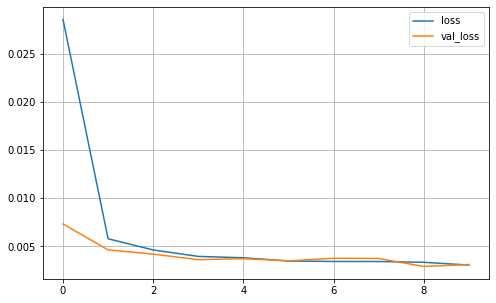

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)

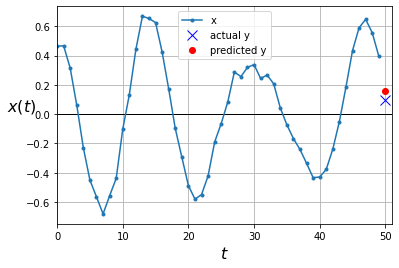

In [ ]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, :], y_valid[0, :], y_pred[0, :])
plt.show()

## 3. 다층 RNN 구현하기 2

In [ ]:
# RNN 모형의 골격 만들기
with tf.device('/device:GPU:0'):
  model=keras.models.Sequential()
  model.add(keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None,1]))
  model.add(keras.layers.SimpleRNN(20))
  model.add(keras.layers.Dense(1))


In [ ]:
# 모형 컴파일 하기

model.compile(loss='mse', optimizer='adam')

In [ ]:
model.summary()
# (20*1)+1

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_6 (SimpleRNN)    (None, None, 20)          440       
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 20)                820       
                                                                 
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 모형 학습하기

history=model.fit(X_train, y_train, epochs=5, validation_data=(X_valid, y_valid))


Epoch 1/5
219/219 [==============================] - 18s 76ms/step - loss: 0.0161 - val_loss: 0.0047
Epoch 2/5
219/219 [==============================] - 17s 79ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 3/5
219/219 [==============================] - 16s 74ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 4/5
219/219 [==============================] - 18s 83ms/step - loss: 0.0030 - val_loss: 0.0034
Epoch 5/5
219/219 [==============================] - 16s 75ms/step - loss: 0.0029 - val_loss: 0.0028


In [ ]:
# 학습결과 확인하기

model.evaluate(X_test, y_test)

32/32 [==============================] - 0s 9ms/step - loss: 0.0028


0.002836826955899596

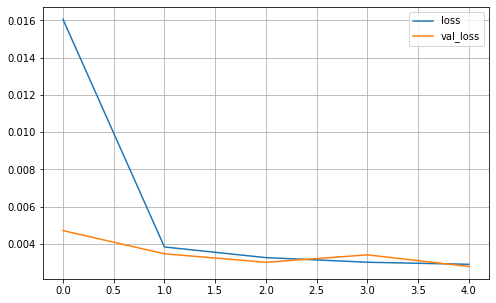

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)

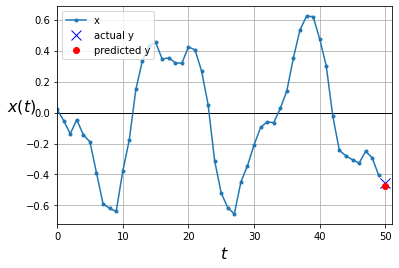

In [ ]:
y_pred = model.predict(X_valid)
plot_series(X_valid[1, :, :], y_valid[1, :], y_pred[1, :])
plt.show()

## 4. 순환 신경망 모형 이용하여 multi-step forecasting 하기

### 4.1 앞의 모형을 이용하여 one-step forcasting 으로 다음값을 예측한 후, 이를 다시 입력값으로 사용하는 방법

In [ ]:
#테스트용 데이터 하나 생성하기

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new

#학습한 모형을 이용하여 테스트용 데이터의 향후 10 스텝 예측하기

for step_ahead in range(10):
  y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
  X = np.concatenate([X, y_pred_one], axis=1)
Y_pred = X[:, n_steps:]


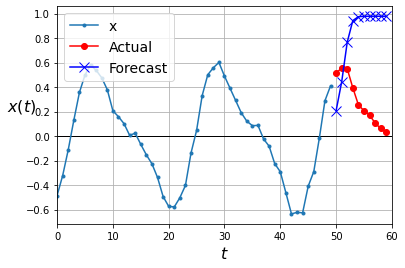

In [ ]:
# 예측 결과와 실제 값 비교하기

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()


### 4.2 multi-step 을 한번에 예측하는 모형을 이용하는 방법

In [ ]:
# 데이터셋 준비 (multi-step 예측이 가능한 모형을 학습하기 위해 "적절한" 학습용 데이터를 먼저 구축해야 함. )
# X 는 그대로 사용하되, target Y 를 변경해야 함.

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [ ]:
np.shape(Y_train)

(7000, 10)

In [ ]:
# RNN 모형의 골격 만들기
with tf.device('/device:GPU:0'):
  model = keras.models.Sequential()
  model.add( keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]) )
  model.add( keras.layers.SimpleRNN(20) )
  model.add( keras.layers.Dense(10) )


In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, None, 20)          440       
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 20)                820       
                                                                 
 dense_2 (Dense)             (None, 10)                210       
                                                                 
Total params: 1,470
Trainable params: 1,470
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 모형 컴파일 및 학습하기 

model.compile(loss='mse', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=5, validation_data=(X_valid, Y_valid))


Epoch 1/5
219/219 [==============================] - 18s 76ms/step - loss: 0.0669 - val_loss: 0.0321
Epoch 2/5
219/219 [==============================] - 16s 74ms/step - loss: 0.0283 - val_loss: 0.0221
Epoch 3/5
219/219 [==============================] - 16s 75ms/step - loss: 0.0199 - val_loss: 0.0160
Epoch 4/5
219/219 [==============================] - 16s 75ms/step - loss: 0.0164 - val_loss: 0.0157
Epoch 5/5
219/219 [==============================] - 16s 74ms/step - loss: 0.0149 - val_loss: 0.0129


In [ ]:
# 학습 결과 확인하기

model.evaluate(X_test, Y_test)

32/32 [==============================] - 0s 9ms/step - loss: 0.0131


0.013141228817403316

In [ ]:
#테스트용 데이터 하나 생성하기

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new

#학습한 모형을 이용하여 테스트용 데이터의 향후 10 스텝 예측하기

Y_pred=model.predict(X_new)[..., np.newaxis]

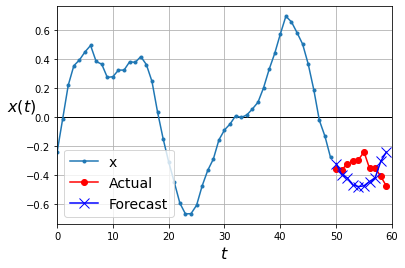

In [ ]:
# 예측 결과와 실제 값 비교하기

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()


### 4.3 각 시점마다 multi-step 을 예측하는 모형 구현하기

return_sequences=True의 의미는 LSTM의 중간 스텝의 출력을 모두 사용하라는 

의미다. 그리고 TimeDistributed() 함수의 의미는 각 스텝마다 cost (오류)를 

계산해서 하위 스텝으로 오류를 전파하여 각 weight를 업데이트하라는 의미다

In [ ]:
# 데이터셋 준비 (각 시점마다 multi-step 예측이 가능한 모형을 학습하기 위해 "적절한" 학습용 데이터를 먼저 구축해야 함. )
# X 는 그대로 사용하되, target Y 를 변경해야 함.
# 전체 타임스텝에서 미래 타임스텝 10개의 값을 예측하도록 설정
# 이전꺼는 마지막에서 10개

Y = np.empty((10000, n_steps, 10)) 
for step_ahead in range(1, 10 + 1):
  Y[:, :, step_ahead - 1] = series[:, step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [ ]:
np.shape(Y_train)

(7000, 50, 10)

In [6]:
# RNN 모형의 골격 만들기
### TimeDistributed layer 의 사용 
with tf.device('/device:GPU:0'):
  model = keras.models.Sequential()
  model.add(keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]))
  model.add(keras.layers.SimpleRNN(20, return_sequences=True))
  model.add(keras.layers.TimeDistributed(keras.layers.Dense(10)))

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, None, 20)          440       
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, None, 20)          820       
                                                                 
 time_distributed (TimeDistr  (None, None, 10)         210       
 ibuted)                                                         
                                                                 
Total params: 1,470
Trainable params: 1,470
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 모형 컴파일 및 학습하기

def last_time_step_mse(Y_true, Y_pred):
  return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss='mse', optimizer='adam', metrics=[last_time_step_mse])

history = model.fit(X_train, Y_train, epochs=5, validation_data=(X_valid, Y_valid))

Epoch 1/5
219/219 [==============================] - 18s 76ms/step - loss: 0.0806 - last_time_step_mse: 0.0710 - val_loss: 0.0192 - val_last_time_step_mse: 0.0179
Epoch 2/5
219/219 [==============================] - 16s 75ms/step - loss: 0.0115 - last_time_step_mse: 0.0132 - val_loss: 0.0040 - val_last_time_step_mse: 0.0036
Epoch 3/5
219/219 [==============================] - 16s 75ms/step - loss: 0.0022 - last_time_step_mse: 0.0020 - val_loss: 0.0013 - val_last_time_step_mse: 0.0011
Epoch 4/5
219/219 [==============================] - 16s 75ms/step - loss: 0.0011 - last_time_step_mse: 0.0011 - val_loss: 9.3528e-04 - val_last_time_step_mse: 0.0012
Epoch 5/5
219/219 [==============================] - 17s 76ms/step - loss: 8.4526e-04 - last_time_step_mse: 9.6546e-04 - val_loss: 7.6731e-04 - val_last_time_step_mse: 0.0010


In [ ]:
model.summary()
# 모든 타임 스텝에서 출력을 Dense 층에 적용하는 역할을 한다. 쉽게 말해 매 스텝마다 FC가 연결된 것처럼 이해할 수 있다. 각 타임 스텝을 별개의 샘플처럼 다루도록 입력의 크기를 바꾸어 이를 효과적으로 수행한다.
# (20*10) + 10

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, None, 20)          440       
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, None, 20)          820       
                                                                 
 time_distributed (TimeDistr  (None, None, 10)         210       
 ibuted)                                                         
                                                                 
Total params: 1,470
Trainable params: 1,470
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 학습결과 확인하기

model.evaluate (X_test, Y_test)

32/32 [==============================] - 0s 9ms/step - loss: 0.0016 - last_time_step_mse: 0.0026


[0.0015931702218949795, 0.002641686238348484]

## 5. 깊은 순환 신경망 모형 학습하기

### 5.1 Layer Normalization (RNN 의 정규화 방법) 구현하기

배치 정규화가 안되기때문에 레이어 정규화를 사용함.

CNN 에서는 BN만으로도 충분할 수 있지만 RNN 에서는 BN을 사용하기 어렵다.

RNN 에서 BN을 사용할 대는 시퀀스에 따라서 파라미터 크기가 달라진다.

In [ ]:
# Layer Normalization 을 적용한 memory cell 만들기

class LNSimpleRNNCell(keras.layers.Layer):
  def __init__(self, units, activation="tanh", **kwargs):
    super().__init__(**kwargs)
    self.state_size = units
    self.output_size = units
    self.simple_rnn_cell = keras.layers.SimpleRNNCell(units, activation=None)
    self.layer_norm = keras.layers.LayerNormalization()
    self.activation = keras.activations.get(activation)
  def call(self, inputs, states):
    outputs, new_states = self.simple_rnn_cell(inputs, states)
    norm_outputs = self.activation(self.layer_norm(outputs))
    return norm_outputs, [norm_outputs]

In [ ]:
# 위의 memory cell 을 이용하여 RNN 모형의 골격 만들기
# cell state
model = keras.models.Sequential()
model.add(keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True, input_shape=[None, 1]))
model.add(keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(10)))


NameError: ignored

In [ ]:
#모형 컴파일 하기

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])


In [ ]:
# 모형 학습하기

history = model.fit(X_train, Y_train, epochs=5, validation_data=(X_valid, Y_valid))


Epoch 1/5
219/219 [==============================] - 56s 245ms/step - loss: 0.0352 - last_time_step_mse: 0.0207 - val_loss: 0.0335 - val_last_time_step_mse: 0.0190
Epoch 2/5
219/219 [==============================] - 55s 250ms/step - loss: 0.0325 - last_time_step_mse: 0.0178 - val_loss: 0.0313 - val_last_time_step_mse: 0.0171
Epoch 3/5
219/219 [==============================] - 52s 239ms/step - loss: 0.0323 - last_time_step_mse: 0.0172 - val_loss: 0.0362 - val_last_time_step_mse: 0.0214
Epoch 4/5
219/219 [==============================] - 52s 236ms/step - loss: 0.0316 - last_time_step_mse: 0.0162 - val_loss: 0.0301 - val_last_time_step_mse: 0.0151
Epoch 5/5
219/219 [==============================] - 52s 237ms/step - loss: 0.0303 - last_time_step_mse: 0.0154 - val_loss: 0.0297 - val_last_time_step_mse: 0.0148


In [ ]:
# 학습 결과 확인하기 

model.evaluate(X_test, Y_test)

32/32 [==============================] - 1s 23ms/step - loss: 0.0290 - last_time_step_mse: 0.0143


[0.029022742062807083, 0.014254474081099033]

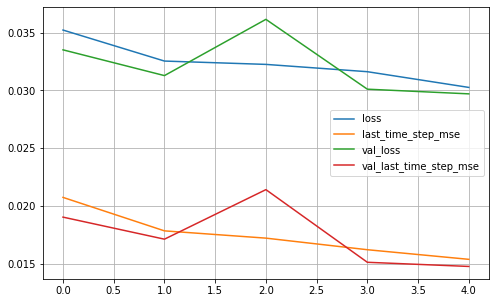

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)

### 5.2 LSTM 모형 구현하기

In [1]:
# LSTM 모형의 골격 만들기

with tf.device('/device:GPU:0'):
  model = keras.models.Sequential()
  model.add(keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]))
  model.add(keras.layers.LSTM(20, return_sequences=True))
  model.add(keras.layers.TimeDistributed(keras.layers.Dense(10)))

NameError: ignored

In [ ]:
# 동일한 다른 방법

with tf.device('/device:GPU:0'):
  model = keras.models.Sequential()
  model.add( keras.layers.RNN(keras.layers.LSTMCell(20), return_sequences=True, input_shape=[None, 1]) )
  model.add( keras.layers.RNN(keras.layers.LSTMCell(20), return_sequences=True) )
  model.add( keras.layers.TimeDistributed(keras.layers.Dense(10)) )

In [ ]:
# 모형 컴파일 하기

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])


In [ ]:
np.shape(X_train)

(7000, 50, 1)

In [ ]:
model.summary()
# 4((파라미터 아웃값*디멘션)+파라미터 아웃값^2+파라미터 아웃값)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rnn_2 (RNN)                 (None, None, 20)          1760      
                                                                 
 rnn_3 (RNN)                 (None, None, 20)          3280      
                                                                 
 time_distributed_2 (TimeDis  (None, None, 10)         210       
 tributed)                                                       
                                                                 
Total params: 5,250
Trainable params: 5,250
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 모형 학습하기 

history = model.fit(X_train, Y_train, epochs=5, validation_data=(X_valid, Y_valid))


Epoch 1/5
219/219 [==============================] - 56s 244ms/step - loss: 0.0796 - last_time_step_mse: 0.0657 - val_loss: 0.0537 - val_last_time_step_mse: 0.0342
Epoch 2/5
219/219 [==============================] - 50s 230ms/step - loss: 0.0460 - last_time_step_mse: 0.0246 - val_loss: 0.0390 - val_last_time_step_mse: 0.0174
Epoch 3/5
219/219 [==============================] - 50s 230ms/step - loss: 0.0371 - last_time_step_mse: 0.0165 - val_loss: 0.0348 - val_last_time_step_mse: 0.0162
Epoch 4/5
219/219 [==============================] - 50s 228ms/step - loss: 0.0337 - last_time_step_mse: 0.0145 - val_loss: 0.0319 - val_last_time_step_mse: 0.0133
Epoch 5/5
219/219 [==============================] - 50s 231ms/step - loss: 0.0317 - last_time_step_mse: 0.0134 - val_loss: 0.0310 - val_last_time_step_mse: 0.0144


In [ ]:
# 학습 결과 확인하기 

model.evaluate(X_test, Y_test)

32/32 [==============================] - 1s 21ms/step - loss: 0.0307 - last_time_step_mse: 0.0137


[0.030727339908480644, 0.0136957922950387]

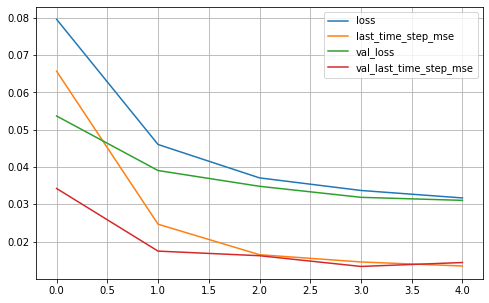

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)

### 5.3 GRU 모형 구현하기

In [ ]:
# 합성곱 층을 포함한 GRU 모형의 골격 만들기
# LSTM보다 파라미터가 더욱 적어 연산 비용도 적고, 모델도 간단해 학습 속도가 더 빠르지만 비슷한 성능을 내는 모델
with tf.device('/device:GPU:0'):
  model = keras.models.Sequential()
  model.add( keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid", input_shape=[None, 1]) )
  model.add( keras.layers.GRU(20, return_sequences=True) )
  model.add( keras.layers.GRU(20, return_sequences=True) )
  model.add( keras.layers.TimeDistributed(keras.layers.Dense(10)) )

In [ ]:
model.summary()
# 3(n^2+m*n+2n)
# n = output
# m = input

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 20)          100       
                                                                 
 gru (GRU)                   (None, None, 20)          2520      
                                                                 
 gru_1 (GRU)                 (None, None, 20)          2520      
                                                                 
 time_distributed_3 (TimeDis  (None, None, 10)         210       
 tributed)                                                       
                                                                 
Total params: 5,350
Trainable params: 5,350
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 모형 컴파일 하기

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])


In [ ]:
# 모형 학습하기

history = model.fit(X_train, Y_train[:, 3::2], epochs=5, validation_data=(X_valid, Y_valid[:, 3::2]))


Epoch 1/5
219/219 [==============================] - 15s 20ms/step - loss: 0.0708 - last_time_step_mse: 0.0633 - val_loss: 0.0470 - val_last_time_step_mse: 0.0392
Epoch 2/5
219/219 [==============================] - 3s 15ms/step - loss: 0.0397 - last_time_step_mse: 0.0331 - val_loss: 0.0354 - val_last_time_step_mse: 0.0284
Epoch 3/5
219/219 [==============================] - 3s 15ms/step - loss: 0.0317 - last_time_step_mse: 0.0243 - val_loss: 0.0290 - val_last_time_step_mse: 0.0205
Epoch 4/5
219/219 [==============================] - 3s 15ms/step - loss: 0.0279 - last_time_step_mse: 0.0190 - val_loss: 0.0260 - val_last_time_step_mse: 0.0165
Epoch 5/5
219/219 [==============================] - 3s 15ms/step - loss: 0.0259 - last_time_step_mse: 0.0160 - val_loss: 0.0245 - val_last_time_step_mse: 0.0142


In [ ]:
# 학습 결과 확인하기

model.evaluate(X_test, Y_test[:, 3::2])

32/32 [==============================] - 0s 7ms/step - loss: 0.0239 - last_time_step_mse: 0.0143


[0.023877957835793495, 0.014272806234657764]

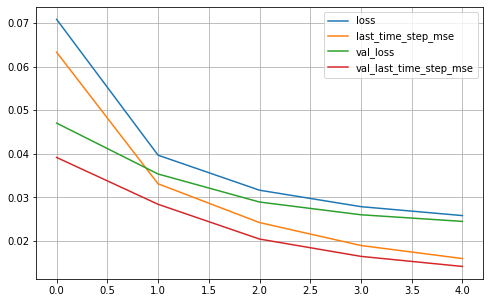

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)

In [ ]:
with tf.device('/device:GPU:0'):
  model = keras.models.Sequential()
  model.add( keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]) )
  model.add( keras.layers.SimpleRNN(20) )
  model.add( keras.layers.Dense(10) )

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, None, 20)          440       
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 20)                820       
                                                                 
 dense_3 (Dense)             (None, 10)                210       
                                                                 
Total params: 1,470
Trainable params: 1,470
Non-trainable params: 0
_________________________________________________________________


In [ ]:
with tf.device('/device:GPU:0'):
  model = keras.models.Sequential()
  model.add(keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]))
  model.add(keras.layers.SimpleRNN(20, return_sequences=True))
  model.add(keras.layers.TimeDistributed(keras.layers.Dense(10)))

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_6 (SimpleRNN)    (None, None, 20)          440       
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, None, 20)          820       
                                                                 
 time_distributed_1 (TimeDis  (None, None, 10)         210       
 tributed)                                                       
                                                                 
Total params: 1,470
Trainable params: 1,470
Non-trainable params: 0
_________________________________________________________________
